If running on google colab, uncomment this cell to install thoi

In [ ]:
#!pip install thoi

In [1]:
import scipy.io
import torch
from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
from thoi.heuristics import simulated_annealing, greedy, simulated_annealing_multi_order
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial
import time
import os
import sys
import zipfile
import urllib.request
device = "cuda" if torch.cuda.is_available() else "cpu"

Helper Functions

In [2]:
def print_time(t_i, t_f):
    elapsed_time_seconds = t_f - t_i
    hours = int(elapsed_time_seconds // 3600)
    minutes = int((elapsed_time_seconds % 3600) // 60)
    seconds = int(elapsed_time_seconds % 60)
    print("Elapsed time: {:02d}:{:02d}:{:02d}".format(hours, minutes, seconds))

## Data

We use freely available data from [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10572216.svg)](https://zenodo.org/records/10572216)



In [3]:
# --- Detect environment ---
if "google.colab" in sys.modules:
    base_path = "/content/cmha_data"
else:
    base_path = os.path.join(os.getcwd(), "cmha_data")

os.makedirs(base_path, exist_ok=True)

url = "https://zenodo.org/records/10572216/files/cmha-1.0.0.zip?download=1"
zip_path = os.path.join(base_path, "cmha-1.0.0.zip")
expected_folder = os.path.join(base_path, "cmha-1.0.0")

# --- Check if already extracted ---
if os.path.exists(expected_folder):
    print(f"✅ Dataset already extracted at: {expected_folder}")
else:
    # --- Download if missing ---
    if not os.path.exists(zip_path):
        print(f"Downloading dataset from Zenodo to {zip_path}...")
        urllib.request.urlretrieve(url, zip_path)
        print("Download complete.")
    else:
        print("✅ Zip file already exists, skipping download.")

    # --- Extract ---
    print("Extracting files...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(base_path)
    print("\nData extracted at:", base_path)

✅ Dataset already extracted at: d:\Camilo\Brain_Entropy\CODES\repo\o-info\cmha_data\cmha-1.0.0


In [4]:
# Load record information
record_metadata = pd.read_csv(f"{base_path}/cmha-1.0.0/data/participants.tsv",delimiter='\t')
# Load fMRI records
data_CoCoMAC = np.load(f"{base_path}/cmha-1.0.0/data/CoCoMac/timeseries.npy")

print("Subjects were recorded under 6 states",record_metadata['cond'].unique())
record_metadata.head(5)
print("\n")
print(f"Data shape {data_CoCoMAC.shape} indicates that there are 156 records from 82 brain regions with 500 samples each")

Subjects were recorded under 6 states ['awake' 'ketamine' 'moderate-propofol' 'deep-propofol'
 'moderate-sevoflurane' 'deep-sevoflurane']


Data shape (156, 500, 82) indicates that there are 156 records from 82 brain regions with 500 samples each


We can store all the information in a dictionary for ease of access

In [11]:
all_states = {}

for state_name in record_metadata['cond'].unique():
    all_states[state_name] = {}
    state_df = record_metadata.query("cond==@state_name")
    sub_idx = 1
    for idx, row in state_df.iterrows():
        all_states[row.cond][sub_idx] = data_CoCoMAC[idx]
        sub_idx+=1

    

In [12]:
for state_name, state_dict in all_states.items():
    state_data = np.stack([state_dict[k] for k in state_dict.keys()], axis=0) # take all awake records
    all_states[state_name] = state_data
    
ts_aw = all_states["awake"]
ts_keta = all_states["ketamine"]
ts_lpp = all_states["moderate-propofol"]
ts_dpp = all_states["deep-propofol"]
ts_selv2 = all_states["moderate-sevoflurane"]
ts_selv4 = all_states["deep-sevoflurane"]

print(ts_aw.shape,   "\n",
      ts_selv2.shape,"\n",
      ts_selv4.shape,"\n",
      ts_lpp.shape,  "\n",
      ts_dpp.shape,  "\n",
      ts_keta.shape)

(31, 500, 82) 
 (25, 500, 82) 
 (20, 500, 82) 
 (25, 500, 82) 
 (30, 500, 82) 
 (25, 500, 82)


This is the function to minimize with Simmulated Annealing. We feed it to : *simulated_annealing(metric=weighted_sum)*. 

It takes the selected metric (between DTC, TC, O and S; in this case O) for each batch and calculates Cohen's d between awake and All the other states in terms of O-Information.

In [13]:

def weighted_sum(batched_measures):
    """
    Weighted sum of Cohen's d values across different altered states.

    Args:
        batched_measures (torch.Tensor): Shape (batch_size, S, 4), where:
            - batch_size: Number of n-plets in the batch.
            - S: Number of subjects.
            - 4: Measures (TC, DTC, O, S).

    Returns:
        torch.Tensor: Weighted sum of Cohen's d values (batch_size,).
    """
    # Drug groups' sizes and cumulative sums. Awake has 24 subjects (check previous cell)
    sizes = torch.tensor(
        [24, 22, 21, 23, 18, 11], dtype=torch.float32, device=batched_measures.device
    )
    cumsum = torch.cumsum(
        sizes, dim=0
    ).long()  
    weights = sizes[1:] / sizes[1:].sum()

    # Awake group (first 24 subjects)
    o_Awake = batched_measures[:, :24, 2]  # Extract O-information for awake state

    mean_Awake = o_Awake.mean(dim=1)
    std_Awake = o_Awake.std(dim=1, unbiased=True)
    F = torch.zeros(
        batched_measures.shape[0], device=batched_measures.device
    )

    start = 24  # Start index after awake
    for w, end in zip(weights, cumsum[1:]):  # Skip the first (awake) weight
        o_Drug = batched_measures[:, start:end, 2]
        mean_Drug = o_Drug.mean(dim=1)
        std_Drug = o_Drug.std(dim=1, unbiased=True)
        pooled_std = torch.sqrt(
            ((o_Awake.size(1) - 1) * std_Awake**2 + (o_Drug.size(1) - 1) * std_Drug**2)
            / (o_Awake.size(1) + o_Drug.size(1) - 2)
        )
        cohen_d = (mean_Drug - mean_Awake) / pooled_std
        F += w * cohen_d # w is the weight corresponding to this state, more subjects -> higher w
        start = int(end) 
    return F

In [14]:
n_repeats = 2 # ideally bigger
batch_size = 1000
X = torch.tensor(np.vstack([ts_aw, ts_keta, ts_lpp, ts_dpp, ts_selv2, ts_selv4])) # we feed the states of interest
T = [X.shape[1]] * X.shape[0]

cohen_list = []
t_i_general = time.time()
for order in range(2, 10):
    t_i = time.time()
    print("order", order, "batch_size:", batch_size)
    min_nplet, min_scores = simulated_annealing(
        X=X,
        order=order,
        device=device,
        T=T,
        largest=False,
        metric=weighted_sum, # Pass the custom metric
        repeat=n_repeats,
        batch_size=batch_size,
    )
    t_f = time.time()
    print(f"Min done, order {order}")
    print_time(t_i, t_f)
    a_ = min_nplet[min_scores.argmin().item()].detach().cpu().tolist()
    a_.sort()
    b_ = min_scores[min_scores.argmin().item()].detach().cpu().tolist()
    cohen_list.append(["min", order, a_, b_])
    torch.cuda.empty_cache()
    t_i = time.time()
    max_nplet, max_scores = simulated_annealing(
        X=X,
        order=order,
        device=device,
        T=T,
        largest=True,
        metric=weighted_sum,  # Pass the custom metric
        repeat=n_repeats,
        batch_size=batch_size,
    )
    t_f = time.time()
    print(f"Max done, order: {order}")
    print_time(t_i, t_f)
    a_ = max_nplet[max_scores.argmax().item()].detach().cpu().tolist()
    a_.sort()
    b_ = max_scores[max_scores.argmax().item()].detach().cpu().tolist()
    cohen_list.append(["max", order, a_, b_])
    torch.cuda.empty_cache()
    print("Total elapsed time:")
    print_time(t_i_general, t_f)

    cols = ["task", "order", "best_nplet", "best_score"]
    cohen_df = pd.DataFrame(cohen_list, columns=cols)
    cohen_df.to_csv(f"weighted_sum_df.csv", index=False)

order 2 batch_size: 1000


mean(weighted_sum) = -0.6810764074325562 - ES: 99:  26%|██▋       | 264/1000 [00:04<00:11, 63.92it/s]2025-10-17 12:18:39,751 - INFO - Early stop reached


Min done, order 2
Elapsed time: 00:00:04


mean(weighted_sum) = 0.6759878396987915 - ES: 99:  28%|██▊       | 276/1000 [00:04<00:12, 58.81it/s]2025-10-17 12:18:44,667 - INFO - Early stop reached


Max done, order: 2
Elapsed time: 00:00:04
Total elapsed time:
Elapsed time: 00:00:09
order 3 batch_size: 1000


mean(weighted_sum) = -1.9140690565109253 - ES: 99:  36%|███▌      | 361/1000 [00:06<00:10, 60.63it/s]2025-10-17 12:18:51,278 - INFO - Early stop reached


Min done, order 3
Elapsed time: 00:00:06


mean(weighted_sum) = 1.0330827236175537 - ES: 99:  14%|█▎        | 135/1000 [00:02<00:13, 63.54it/s]2025-10-17 12:18:53,906 - INFO - Early stop reached


Max done, order: 3
Elapsed time: 00:00:02
Total elapsed time:
Elapsed time: 00:00:18
order 4 batch_size: 1000


mean(weighted_sum) = -1.766396403312683 - ES: 99:  39%|███▉      | 389/1000 [00:06<00:10, 60.78it/s] 2025-10-17 12:19:00,644 - INFO - Early stop reached


Min done, order 4
Elapsed time: 00:00:06


mean(weighted_sum) = 1.032080888748169 - ES: 99:  30%|███       | 301/1000 [00:04<00:11, 61.40it/s] 2025-10-17 12:19:05,937 - INFO - Early stop reached


Max done, order: 4
Elapsed time: 00:00:05
Total elapsed time:
Elapsed time: 00:00:30
order 5 batch_size: 1000


mean(weighted_sum) = -1.7875678539276123 - ES: 99:  26%|██▋       | 264/1000 [00:04<00:12, 59.20it/s]2025-10-17 12:19:10,942 - INFO - Early stop reached


Min done, order 5
Elapsed time: 00:00:04


mean(weighted_sum) = 0.6907975077629089 - ES: 99:  14%|█▍        | 140/1000 [00:02<00:12, 67.05it/s]2025-10-17 12:19:13,560 - INFO - Early stop reached


Max done, order: 5
Elapsed time: 00:00:02
Total elapsed time:
Elapsed time: 00:00:38
order 6 batch_size: 1000


mean(weighted_sum) = -1.7299342155456543 - ES: 99:  27%|██▋       | 274/1000 [00:04<00:12, 57.67it/s]2025-10-17 12:19:18,301 - INFO - Early stop reached


Min done, order 6
Elapsed time: 00:00:04


mean(weighted_sum) = 0.7711973190307617 - ES: 99:  18%|█▊        | 183/1000 [00:02<00:12, 66.58it/s]2025-10-17 12:19:21,509 - INFO - Early stop reached


Max done, order: 6
Elapsed time: 00:00:03
Total elapsed time:
Elapsed time: 00:00:46
order 7 batch_size: 1000


mean(weighted_sum) = -1.9873721599578857 - ES: 99:  26%|██▌       | 259/1000 [00:04<00:11, 65.57it/s]2025-10-17 12:19:26,014 - INFO - Early stop reached


Min done, order 7
Elapsed time: 00:00:04


mean(weighted_sum) = 0.7729606628417969 - ES: 99:  32%|███▏      | 315/1000 [00:04<00:10, 64.64it/s] 2025-10-17 12:19:31,371 - INFO - Early stop reached


Max done, order: 7
Elapsed time: 00:00:05
Total elapsed time:
Elapsed time: 00:00:56
order 8 batch_size: 1000


mean(weighted_sum) = -1.921909213066101 - ES: 99:  22%|██▏       | 222/1000 [00:03<00:12, 62.83it/s]2025-10-17 12:19:35,453 - INFO - Early stop reached


Min done, order 8
Elapsed time: 00:00:04


mean(weighted_sum) = 0.12891258299350739 - ES: 99:  24%|██▍       | 244/1000 [00:04<00:12, 60.77it/s] 2025-10-17 12:19:39,868 - INFO - Early stop reached


Max done, order: 8
Elapsed time: 00:00:04
Total elapsed time:
Elapsed time: 00:01:04
order 9 batch_size: 1000


mean(weighted_sum) = -1.9319581985473633 - ES: 99:  13%|█▎        | 133/1000 [00:02<00:14, 61.23it/s]2025-10-17 12:19:42,534 - INFO - Early stop reached


Min done, order 9
Elapsed time: 00:00:02


mean(weighted_sum) = 0.45430076122283936 - ES: 99:  20%|██        | 205/1000 [00:03<00:14, 55.84it/s]2025-10-17 12:19:46,357 - INFO - Early stop reached
                                                                                                     

Max done, order: 9
Elapsed time: 00:00:03
Total elapsed time:
Elapsed time: 00:01:11


Example results

In [15]:
cohen_df.head(10)

,task,order,best_nplet,best_score
0,min,2,"[16, 40]",-0.719932
1,max,2,"[14, 70]",0.752547
2,min,3,"[14, 38, 55]",-2.008146
3,max,3,"[23, 27, 34]",1.048662
4,min,4,"[22, 30, 54, 65]",-2.144248
5,max,4,"[34, 62, 76, 81]",1.197190
6,min,5,"[10, 23, 38, 49, 79]",-2.130950
7,max,5,"[8, 60, 61, 62, 72]",0.762490
8,min,6,"[14, 22, 32, 34, 64, 73]",-1.790727
9,max,6,"[1, 21, 32, 45, 61, 68]",0.844267


<Axes: xlabel='order', ylabel='best_score'>

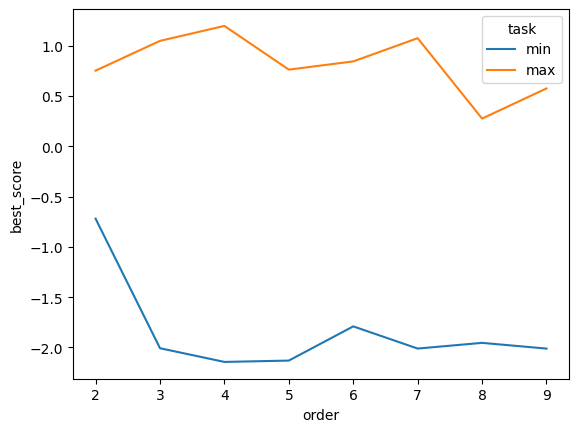

In [16]:
sns.lineplot(cohen_df,x='order',y='best_score',hue='task')